# 3D Covariance Optimization with Divergence-Free Transformation

This notebook demonstrates:
1. Sampling points from a 3D uniform distribution
2. Creating a divergence-free transformation with multiple centers
3. Optimizing coefficients to minimize covariance determinant
4. Visualizing 2D projections (XY, XZ, YZ) before and after
5. If successful, each 2D projection should appear Gaussian

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from entra import (
    VectorSampler, TensorBasis, Transformation, CovarianceMinimizer,
    EffectiveTransformation, EffectiveCovarianceMinimizer,
    shannon_entropy_gaussian, shannon_entropy_uniform, plot_covariance_ellipse, plot_2d_projections
)

## Step 1: Sample Points from 3D Uniform Distribution

In [2]:
# Parameters
D = 3
num_points_per_dim = 10  # 10^3 = 1000 points
delta_x = 1
sigma = 3

# Create sampler centered at origin
sampler = VectorSampler(
    center=[0.0, 0.0, 0.0],
    delta_x=delta_x,
    num_points_per_dim=num_points_per_dim,
    distribution="uniform"
)

# Sample the grid points
eval_points = sampler.sample()
J = sampler.J
grid_shape = sampler.num_points_per_dim

print(f"Grid: {num_points_per_dim}^{D} = {J} points")
print(f"Grid shape: {grid_shape}")
print(f"delta_x = {delta_x}")
print(f"sigma = {sigma}")
print(f"\neval_points shape: {eval_points.shape}  (J, D)")
print(f"\nGrid extent:")
print(f"  x: [{eval_points[:, 0].min():.2f}, {eval_points[:, 0].max():.2f}]")
print(f"  y: [{eval_points[:, 1].min():.2f}, {eval_points[:, 1].max():.2f}]")
print(f"  z: [{eval_points[:, 2].min():.2f}, {eval_points[:, 2].max():.2f}]")

Grid: 10^3 = 1000 points
Grid shape: (10, 10, 10)
delta_x = 1
sigma = 3

eval_points shape: (1000, 3)  (J, D)

Grid extent:
  x: [-4.50, 4.50]
  y: [-4.50, 4.50]
  z: [-4.50, 4.50]


In [ ]:
# Initial statistics
initial_mean = np.mean(eval_points, axis=0)
initial_cov = np.cov(eval_points, rowvar=False)
initial_det = np.linalg.det(initial_cov)
initial_entropy_uniform = shannon_entropy_uniform(eval_points)

print("Initial Distribution Statistics (Uniform):")
print(f"  Mean: [{initial_mean[0]:.4f}, {initial_mean[1]:.4f}, {initial_mean[2]:.4f}]")
print(f"  Covariance diagonal: [{initial_cov[0,0]:.4f}, {initial_cov[1,1]:.4f}, {initial_cov[2,2]:.4f}]")
print(f"  Determinant: {initial_det:.6e}")
print(f"  Volume: {num_points_per_dim * delta_x}^{D} = {(num_points_per_dim * delta_x)**D}")
print(f"  Entropy H(uniform): {initial_entropy_uniform:.6f} nats (target)")

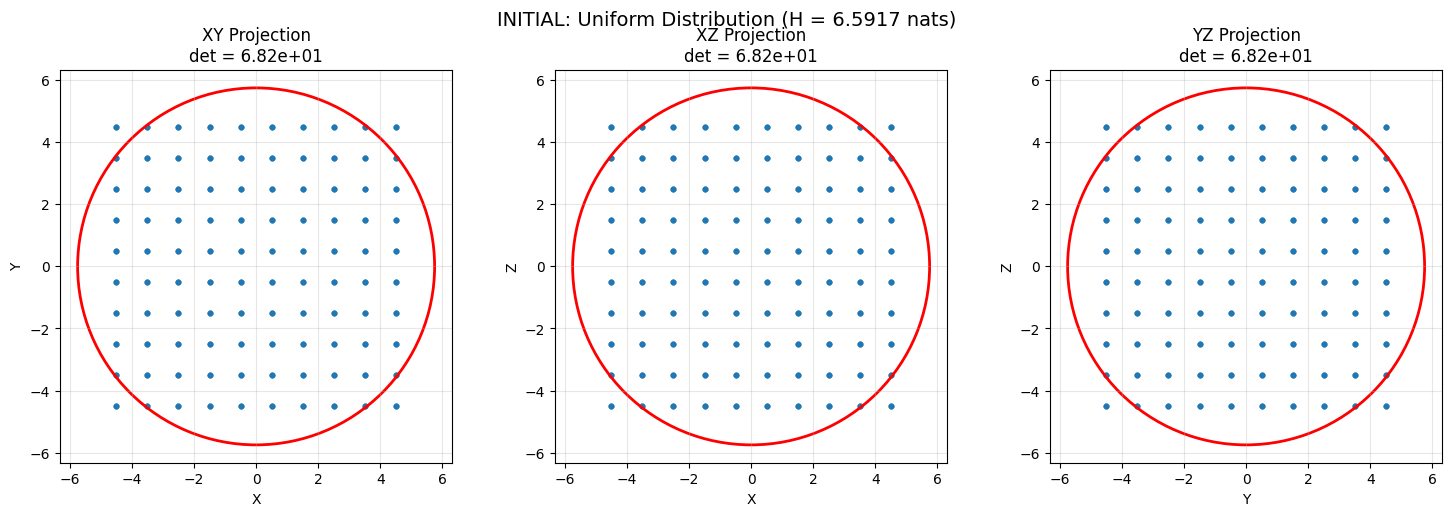

In [4]:
# Visualize initial 2D projections
fig, axes = plot_2d_projections(eval_points, 'INITIAL: Uniform Distribution', initial_entropy_uniform)
plt.show()

## Step 2: Create Centers and Transformation

In [5]:
# Create centers along each axis
center_list = []
max_coord = int(eval_points[:, 0].max())
for i in range(max_coord):
    # Along x-axis
    center_list.append([i, 0.0, 0.0])
    center_list.append([-i, 0.0, 0.0])
    # Along y-axis
    center_list.append([0.0, i, 0.0])
    center_list.append([0.0, -i, 0.0])
    # Along z-axis
    center_list.append([0.0, 0.0, i])
    center_list.append([0.0, 0.0, -i])

centers = np.asarray(center_list)
print(f"Number of centers: {len(centers)}")
print(f"Centers shape: {centers.shape}")

Number of centers: 24
Centers shape: (24, 3)


In [6]:
# Create basis and transformation
basis = TensorBasis(centers, sigma=sigma)
transformation = Transformation(basis)

print(f"TensorBasis: L={basis.L}, D={basis.D}, sigma={sigma}")
print(f"Transformation: {transformation.num_parameters} parameters (L x D = {basis.L} x {basis.D})")

TensorBasis: L=24, D=3, sigma=3
Transformation: 72 parameters (L x D = 24 x 3)


## Step 3: Optimize Coefficients (Levenberg-Marquardt)

In [ ]:
# Create minimizer
minimizer = CovarianceMinimizer(transformation, eval_points)

# Track optimization history
history = {
    'iteration': [],
    'determinant': [],
    'gaussian_entropy': [],
    'log_det': []
}

# Custom optimization to record each step
x = transformation.get_coefficients_flat().copy()
n_params = len(x)

lam = 1.0  # Damping
eps = 1e-7
max_iter = 500
tol = 1e-12

# Record initial
cov = minimizer.compute_covariance(x)
det_val = np.linalg.det(cov)
gaussian_entropy = shannon_entropy_gaussian(cov)
history['iteration'].append(0)
history['determinant'].append(det_val)
history['gaussian_entropy'].append(gaussian_entropy)
history['log_det'].append(np.log(det_val))

print(f"Target H(uniform) = {initial_entropy_uniform:.6f} nats")
print(f"\n{'Iter':>5}  {'Determinant':>14}  {'H(Gaussian)':>12}  {'log(det)':>12}")
print("-" * 50)
print(f"{0:>5}  {det_val:>14.6e}  {gaussian_entropy:>12.6f}  {np.log(det_val):>12.6f}")

for iteration in range(1, max_iter + 1):
    r = minimizer.residuals_for_lm(x)
    
    # Jacobian
    J_mat = np.zeros((len(r), n_params))
    for i in range(n_params):
        x_plus = x.copy()
        x_plus[i] += eps
        J_mat[:, i] = (minimizer.residuals_for_lm(x_plus) - r) / eps
    
    # LM step
    JTJ = J_mat.T @ J_mat
    JTr = J_mat.T @ r
    
    try:
        delta = np.linalg.solve(JTJ + lam * np.eye(n_params), -JTr)
    except:
        delta = -JTr / (np.diag(JTJ) + lam + 1e-10)
    
    x_new = x + delta
    obj_new = minimizer.objective_logdet(x_new)
    obj_old = minimizer.objective_logdet(x)
    
    if obj_new < obj_old:
        x = x_new
        lam *= 0.1
        improvement = abs(obj_old - obj_new)
        
        cov = minimizer.compute_covariance(x)
        det_val = np.linalg.det(cov)
        gaussian_entropy = shannon_entropy_gaussian(cov)
        
        history['iteration'].append(iteration)
        history['determinant'].append(det_val)
        history['gaussian_entropy'].append(gaussian_entropy)
        history['log_det'].append(np.log(det_val))
        
        if iteration % 20 == 0 or iteration <= 5:
            print(f"{iteration:>5}  {det_val:>14.6e}  {gaussian_entropy:>12.6f}  {np.log(det_val):>12.6f}")
        
        if improvement < tol:
            print(f"\nConverged at iteration {iteration}")
            break
    else:
        lam *= 10.0

print(f"\nFinal: det = {det_val:.6e}, H(Gaussian) = {gaussian_entropy:.6f}")
print(f"Gap to target: {gaussian_entropy - initial_entropy_uniform:.6f} nats")

In [8]:
# Set final coefficients
transformation.set_coefficients_flat(x)

## Step 4: Optimization Progress

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Determinant
ax0 = axes[0]
ax0.semilogy(history['iteration'], history['determinant'], 'b.-', linewidth=2, markersize=4)
ax0.set_xlabel('Iteration', fontsize=12)
ax0.set_ylabel('det(Cov)', fontsize=12)
ax0.set_title('Determinant vs Iteration', fontsize=14)
ax0.grid(True, alpha=0.3)

# Log determinant
ax1 = axes[1]
ax1.plot(history['iteration'], history['log_det'], 'g.-', linewidth=2, markersize=4)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('log(det(Cov))', fontsize=12)
ax1.set_title('Log-Determinant vs Iteration', fontsize=14)
ax1.grid(True, alpha=0.3)

# Gaussian entropy with target line
ax2 = axes[2]
ax2.plot(history['iteration'], history['gaussian_entropy'], 'r.-', linewidth=2, markersize=4, label='H(Gaussian)')
ax2.axhline(initial_entropy_uniform, color='green', linestyle='--', linewidth=2, label=f'Target H(uniform) = {initial_entropy_uniform:.4f}')
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Entropy (nats)', fontsize=12)
ax2.set_title('H(Gaussian) → Target H(uniform)', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: Transform Points and Compare

In [ ]:
# Transform points
points_transformed = transformation.transform(eval_points)

# Final statistics
final_mean = np.mean(points_transformed, axis=0)
final_cov = np.cov(points_transformed, rowvar=False)
final_det = np.linalg.det(final_cov)
final_entropy_gaussian = shannon_entropy_gaussian(final_cov)

print("Comparison:")
print(f"{'':20} {'Initial':>14} {'Final':>14} {'Change':>14}")
print("-" * 65)
print(f"{'Determinant':20} {initial_det:>14.6e} {final_det:>14.6e} {initial_det/final_det:>14.2f}x")
print(f"{'H(uniform) target':20} {initial_entropy_uniform:>14.6f}")
print(f"{'H(gaussian)':20} {'':>14} {final_entropy_gaussian:>14.6f}")
print(f"{'Gap to target':20} {'':>14} {final_entropy_gaussian - initial_entropy_uniform:>14.6f}")

## Step 6: Outer Loop with Updated Basis

In [ ]:
# Get updated basis after first iteration
updated_basis = transformation.get_updated_basis(eval_points)  # (J, L, D)

# Outer loop with updated basis
N_OUTER = 5
outer_history = {
    'round': [0], 
    'determinant': [final_det], 
    'gaussian_entropy': [final_entropy_gaussian],
    'points': [points_transformed.copy()],
    'covariance': [final_cov.copy()]
}
current_basis = updated_basis.copy()
current_points = points_transformed.copy()

print(f"Starting outer loop with {N_OUTER} rounds")
print(f"Initial basis shape: {current_basis.shape}")
print(f"Target H(uniform) = {initial_entropy_uniform:.6f} nats")
print(f"\n{'Round':>5}  {'Determinant':>14}  {'H(Gaussian)':>12}")
print("-" * 40)
print(f"{0:>5}  {final_det:>14.6e}  {final_entropy_gaussian:>12.6f}")

for outer_round in range(1, N_OUTER + 1):
    # Create effective transformation with current basis
    eff_transform = EffectiveTransformation(current_basis, current_points)
    eff_minimizer = EffectiveCovarianceMinimizer(eff_transform)
    
    # Optimize
    result = eff_minimizer.optimize(max_iterations=500, tolerance=1e-10, verbose=False)
    
    # Record results
    round_det = result['final_determinant']
    round_cov = result['final_covariance']
    round_entropy = shannon_entropy_gaussian(round_cov)
    
    # Update points for next round
    current_points = eff_transform.transform()
    current_basis = eff_transform.get_updated_basis()
    
    outer_history['round'].append(outer_round)
    outer_history['determinant'].append(round_det)
    outer_history['gaussian_entropy'].append(round_entropy)
    outer_history['points'].append(current_points.copy())
    outer_history['covariance'].append(round_cov.copy())
    
    print(f"{outer_round:>5}  {round_det:>14.6e}  {round_entropy:>12.6f}")

print(f"\nFinal reduction: {outer_history['determinant'][0] / outer_history['determinant'][-1]:.2f}x")
print(f"Final gap to target: {outer_history['gaussian_entropy'][-1] - initial_entropy_uniform:.6f} nats")

In [ ]:
# Plot outer loop progress
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax0 = axes[0]
ax0.semilogy(outer_history['round'], outer_history['determinant'], 'bo-', linewidth=2, markersize=10)
ax0.axhline(initial_det, color='r', linestyle='--', label=f'Initial: {initial_det:.2e}')
ax0.set_xlabel('Outer Round', fontsize=12)
ax0.set_ylabel('det(Cov)', fontsize=12)
ax0.set_title('Determinant vs Outer Round', fontsize=14)
ax0.legend()
ax0.grid(True, alpha=0.3)

ax1 = axes[1]
ax1.plot(outer_history['round'], outer_history['gaussian_entropy'], 'go-', linewidth=2, markersize=10, label='H(Gaussian)')
ax1.axhline(initial_entropy_uniform, color='r', linestyle='--', label=f'Target H(uniform): {initial_entropy_uniform:.4f}')
ax1.set_xlabel('Outer Round', fontsize=12)
ax1.set_ylabel('Entropy (nats)', fontsize=12)
ax1.set_title('H(Gaussian) → Target H(uniform)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 7: Compare 2D Projections Before and After

If the optimization worked, each 2D projection should look Gaussian (elliptical contours).

In [ ]:
# Get final transformed points
final_points = outer_history['points'][-1]
final_cov_outer = outer_history['covariance'][-1]
final_entropy_outer = outer_history['gaussian_entropy'][-1]

# Before: Initial uniform distribution (show 3D entropy)
print("BEFORE: Initial Uniform Distribution")
print(f"3D Entropy H(uniform) = {initial_entropy_uniform:.6f} nats")
fig1, axes1 = plot_2d_projections(eval_points, f'BEFORE: Uniform Distribution\nH(uniform) = {initial_entropy_uniform:.4f} nats')
plt.show()

# After: Final transformed distribution (show 3D entropy)
print(f"\nAFTER: Final Transformed Distribution")
print(f"3D Entropy H(Gaussian) = {final_entropy_outer:.6f} nats")
fig2, axes2 = plot_2d_projections(final_points, f'AFTER: Transformed Distribution\nH(Gaussian) = {final_entropy_outer:.4f} nats')
plt.show()

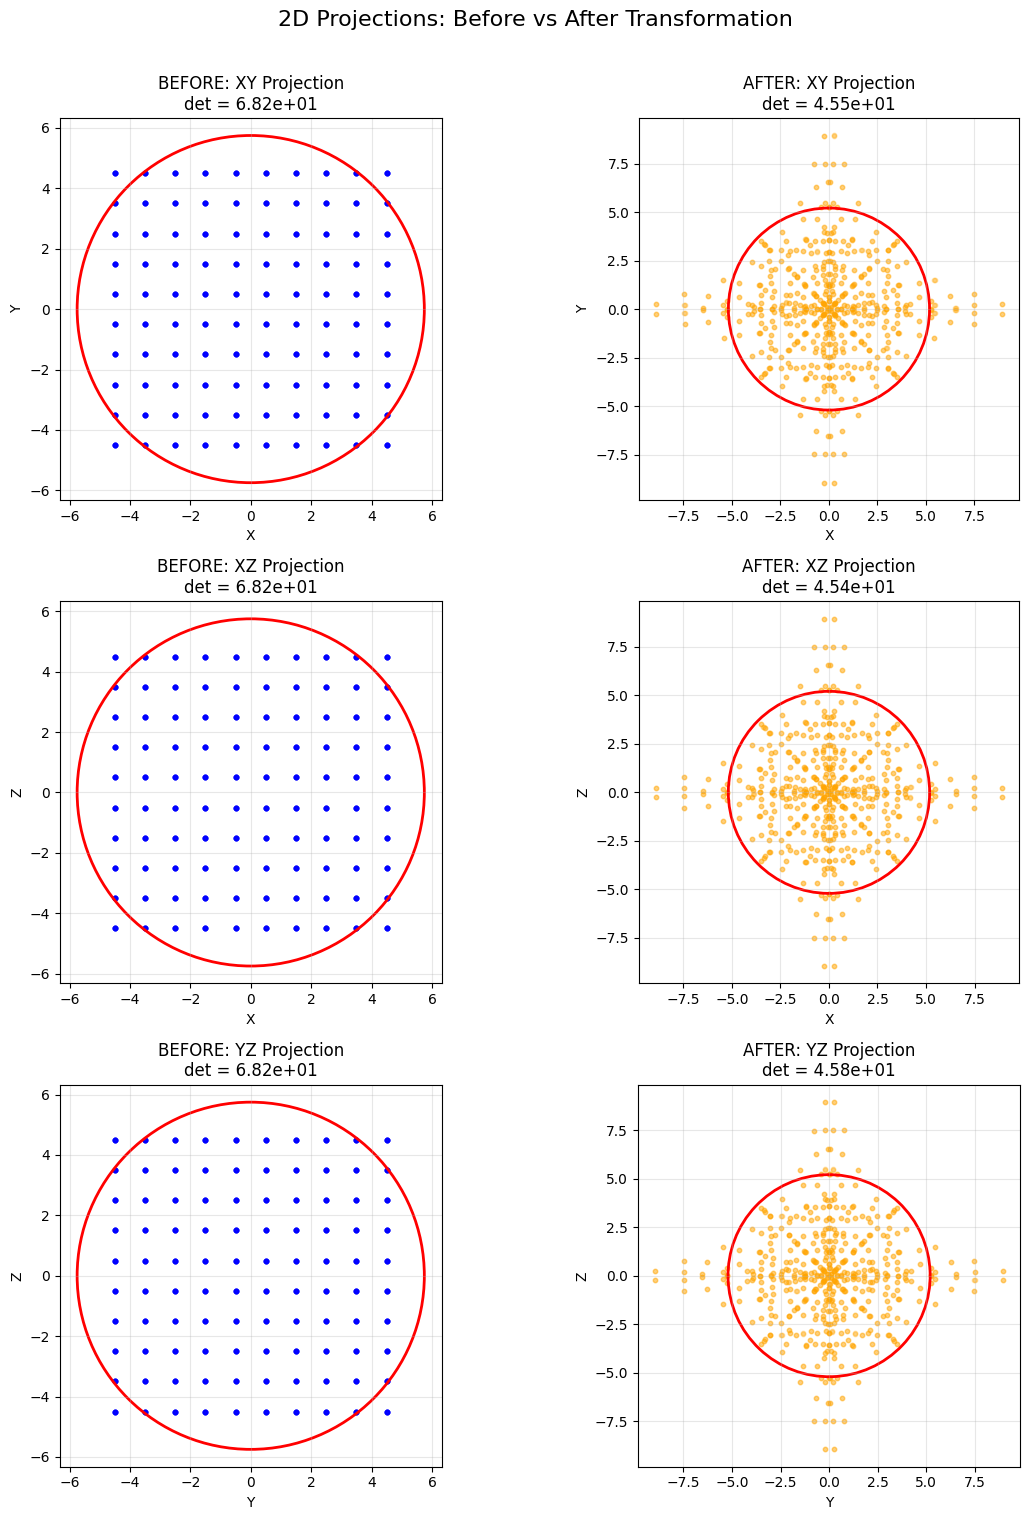

In [14]:
# Side-by-side comparison for each projection
projections = [
    (0, 1, 'XY', 'X', 'Y'),
    (0, 2, 'XZ', 'X', 'Z'),
    (1, 2, 'YZ', 'Y', 'Z')
]

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

for row, (i, j, name, xlabel, ylabel) in enumerate(projections):
    # Before
    ax_before = axes[row, 0]
    pts_before = eval_points[:, [i, j]]
    mean_before = np.mean(pts_before, axis=0)
    cov_before = np.cov(pts_before, rowvar=False)
    det_before = np.linalg.det(cov_before)
    
    ax_before.scatter(pts_before[:, 0], pts_before[:, 1], alpha=0.3, s=10, c='blue')
    plot_covariance_ellipse(ax_before, mean_before, cov_before, n_std=2,
                            fill=False, color='red', linewidth=2)
    ax_before.set_xlabel(xlabel)
    ax_before.set_ylabel(ylabel)
    ax_before.set_title(f'BEFORE: {name} Projection\ndet = {det_before:.2e}')
    ax_before.set_aspect('equal')
    ax_before.grid(True, alpha=0.3)
    
    # After
    ax_after = axes[row, 1]
    pts_after = final_points[:, [i, j]]
    mean_after = np.mean(pts_after, axis=0)
    cov_after = np.cov(pts_after, rowvar=False)
    det_after = np.linalg.det(cov_after)
    
    ax_after.scatter(pts_after[:, 0], pts_after[:, 1], alpha=0.3, s=10, c='orange')
    plot_covariance_ellipse(ax_after, mean_after, cov_after, n_std=2,
                            fill=False, color='red', linewidth=2)
    ax_after.set_xlabel(xlabel)
    ax_after.set_ylabel(ylabel)
    ax_after.set_title(f'AFTER: {name} Projection\ndet = {det_after:.2e}')
    ax_after.set_aspect('equal')
    ax_after.grid(True, alpha=0.3)

plt.suptitle('2D Projections: Before vs After Transformation', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

## Step 8: Distribution Evolution Through Outer Loop

In [ ]:
# Show evolution of XY projection through outer loop
n_plots = 1 + len(outer_history['round'])  # Initial + all rounds
n_cols = min(4, n_plots)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = np.atleast_2d(axes).flatten()

# Plot 0: Initial uniform (XY projection)
ax = axes[0]
pts_2d = eval_points[:, [0, 1]]
mean_2d = np.mean(pts_2d, axis=0)
cov_2d = np.cov(pts_2d, rowvar=False)
ax.scatter(pts_2d[:, 0], pts_2d[:, 1], alpha=0.3, s=10, c='blue')
plot_covariance_ellipse(ax, mean_2d, cov_2d, n_std=2, fill=False, color='red', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Initial (Uniform)\nH(uniform) = {initial_entropy_uniform:.4f}')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Plot 1+: After each outer round
for idx, (rnd, pts, ent) in enumerate(zip(
    outer_history['round'], 
    outer_history['points'],
    outer_history['gaussian_entropy']
)):
    ax = axes[idx + 1]
    pts_2d = pts[:, [0, 1]]
    mean_2d = np.mean(pts_2d, axis=0)
    cov_2d = np.cov(pts_2d, rowvar=False)
    
    color = plt.cm.viridis(idx / max(1, len(outer_history['round']) - 1))
    ax.scatter(pts_2d[:, 0], pts_2d[:, 1], alpha=0.3, s=10, c=[color])
    plot_covariance_ellipse(ax, mean_2d, cov_2d, n_std=2, fill=False, color='red', linewidth=2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    if rnd == 0:
        ax.set_title(f'After 1st Iter\nH(Gaussian) = {ent:.4f}')
    else:
        ax.set_title(f'Outer Round {rnd}\nH(Gaussian) = {ent:.4f}')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(n_plots, len(axes)):
    axes[j].set_visible(False)

plt.suptitle(f'XY Projection Evolution (Target H(uniform) = {initial_entropy_uniform:.4f})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Summary

The 3D optimization:
- Started with a uniform distribution on a 3D grid
- Applied divergence-free transformations to minimize covariance determinant
- Each 2D projection should show a transition from uniform (rectangular) to Gaussian (elliptical)
- The covariance ellipses in each projection indicate the shape of the distribution